In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("🌲 Forest Cover Type Prediction Analysis")
print("=" * 50)

🌲 Forest Cover Type Prediction Analysis


In [3]:
print("\n📊 Step 1: Loading and Exploring Data")
print("-" * 40)
df = pd.read_csv('forest_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")



📊 Step 1: Loading and Exploring Data
----------------------------------------
Dataset shape: (10000, 55)
Columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54']


In [4]:
feature_names = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
wilderness_areas = [f'Wilderness_Area_{i}' for i in range(1, 5)]
soil_types = [f'Soil_Type_{i}' for i in range(1, 41)]
all_columns = feature_names + wilderness_areas + soil_types + ['Cover_Type']
df.columns = all_columns
print(f"✅ Renamed columns to meaningful names")
print(f"   • Cartographic features: {len(feature_names)}")
print(f"   • Wilderness areas: {len(wilderness_areas)}")
print(f"   • Soil types: {len(soil_types)}")
print(f"   • Target: Cover_Type")

✅ Renamed columns to meaningful names
   • Cartographic features: 10
   • Wilderness areas: 4
   • Soil types: 40
   • Target: Cover_Type


In [5]:
print("\n📋 Dataset Info:")
df.info()

print(f"\n❌ Missing values:\n{df.isnull().sum().sum()}")



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           10000 non-null  int64
 1   Aspect                              10000 non-null  int64
 2   Slope                               10000 non-null  int64
 3   Horizontal_Distance_To_Hydrology    10000 non-null  int64
 4   Vertical_Distance_To_Hydrology      10000 non-null  int64
 5   Horizontal_Distance_To_Roadways     10000 non-null  int64
 6   Hillshade_9am                       10000 non-null  int64
 7   Hillshade_Noon                      10000 non-null  int64
 8   Hillshade_3pm                       10000 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  10000 non-null  int64
 10  Wilderness_Area_1                   10000 non-null  int64
 11  Wilderness_Area_2                   10000 non-null 

In [6]:
print("\n🔍 First 5 rows:")
display(df.head())


🔍 First 5 rows:


Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2683     333     35                                30   
1       2915      90      8                               216   
2       2941     162      7                               698   
3       3096      60     17                               170   
4       2999      66      8                               488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              26                             2743   
1                              11                             4433   
2                              76                             2783   
3                               3                             3303   
4                              37                             1532   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            121             173            179   
1            232             228            129   
2            227             242            148   
3            231             202             99   
4            228             225            131   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type_32  Soil_Type_33  \
0                                6572  ...             0             0   
1                                4019  ...             0             0   
2                                1784  ...             0             0   
3                                5370  ...             0             0   
4                                2290  ...             0             0   

   Soil_Type_34  Soil_Type_35  Soil_Type_36  Soil_Type_37  Soil_Type_38  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Soil_Type_39  Soil_Type_40  Cover_Type  
0             0             0           2  
1             0             0           1  
2             0             0           2  
3             0             0           1  
4             0             0           2  

[5 rows x 55 columns]

In [7]:
print(f"\n🎯 Target Variable Analysis:")
cover_type_counts = df['Cover_Type'].value_counts().sort_index()
print("Cover Type Distribution:")
for cover_type, count in cover_type_counts.items():
    percentage = count / len(df) * 100
    print(f"   Type {cover_type}: {count:4d} samples ({percentage:5.1f}%)")
print("\n📈 Statistical Summary (Cartographic Features):")
display(df[feature_names].describe())


🎯 Target Variable Analysis:
Cover Type Distribution:
   Type 1: 3690 samples ( 36.9%)
   Type 2: 4876 samples ( 48.8%)
   Type 3:  590 samples (  5.9%)
   Type 4:   51 samples (  0.5%)
   Type 5:  162 samples (  1.6%)
   Type 6:  302 samples (  3.0%)
   Type 7:  329 samples (  3.3%)

📈 Statistical Summary (Cartographic Features):


Elevation        Aspect        Slope  \
count  10000.000000  10000.000000  10000.00000   
mean    2960.645900    154.127600     13.98120   
std      276.101899    111.112044      7.44313   
min     1866.000000      0.000000      0.00000   
25%     2819.000000     57.000000      9.00000   
50%     2996.000000    128.000000     13.00000   
75%     3162.000000    254.000000     18.00000   
max     3846.000000    359.000000     57.00000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      10000.000000                    10000.000000   
mean                         269.502800                       45.596800   
std                          214.741609                       57.607363   
min                            0.000000                     -147.000000   
25%                          108.000000                        6.000000   
50%                          218.000000                       29.000000   
75%                          390.000000                       68.000000   
max                         1370.000000                      573.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     10000.000000   10000.000000    10000.000000   
mean                       2358.805400     212.382200      223.886000   
std                        1564.814207      26.560675       19.443395   
min                           0.000000      70.000000       88.000000   
25%                        1106.750000     199.000000      213.000000   
50%                        2008.000000     218.000000      227.000000   
75%                        3330.250000     231.000000      238.000000   
max                        7023.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  
count   10000.000000                        10000.000000  
mean      142.892300                         1982.005000  
std        37.460182                         1307.685368  
min         0.000000                            0.000000  
25%       120.000000                         1041.000000  
50%       143.000000                         1719.000000  
75%       167.000000                         2542.250000  
max       247.000000                         7080.000000


🔍 Step 2: Data Exploration and Visualization
------------------------------------------------


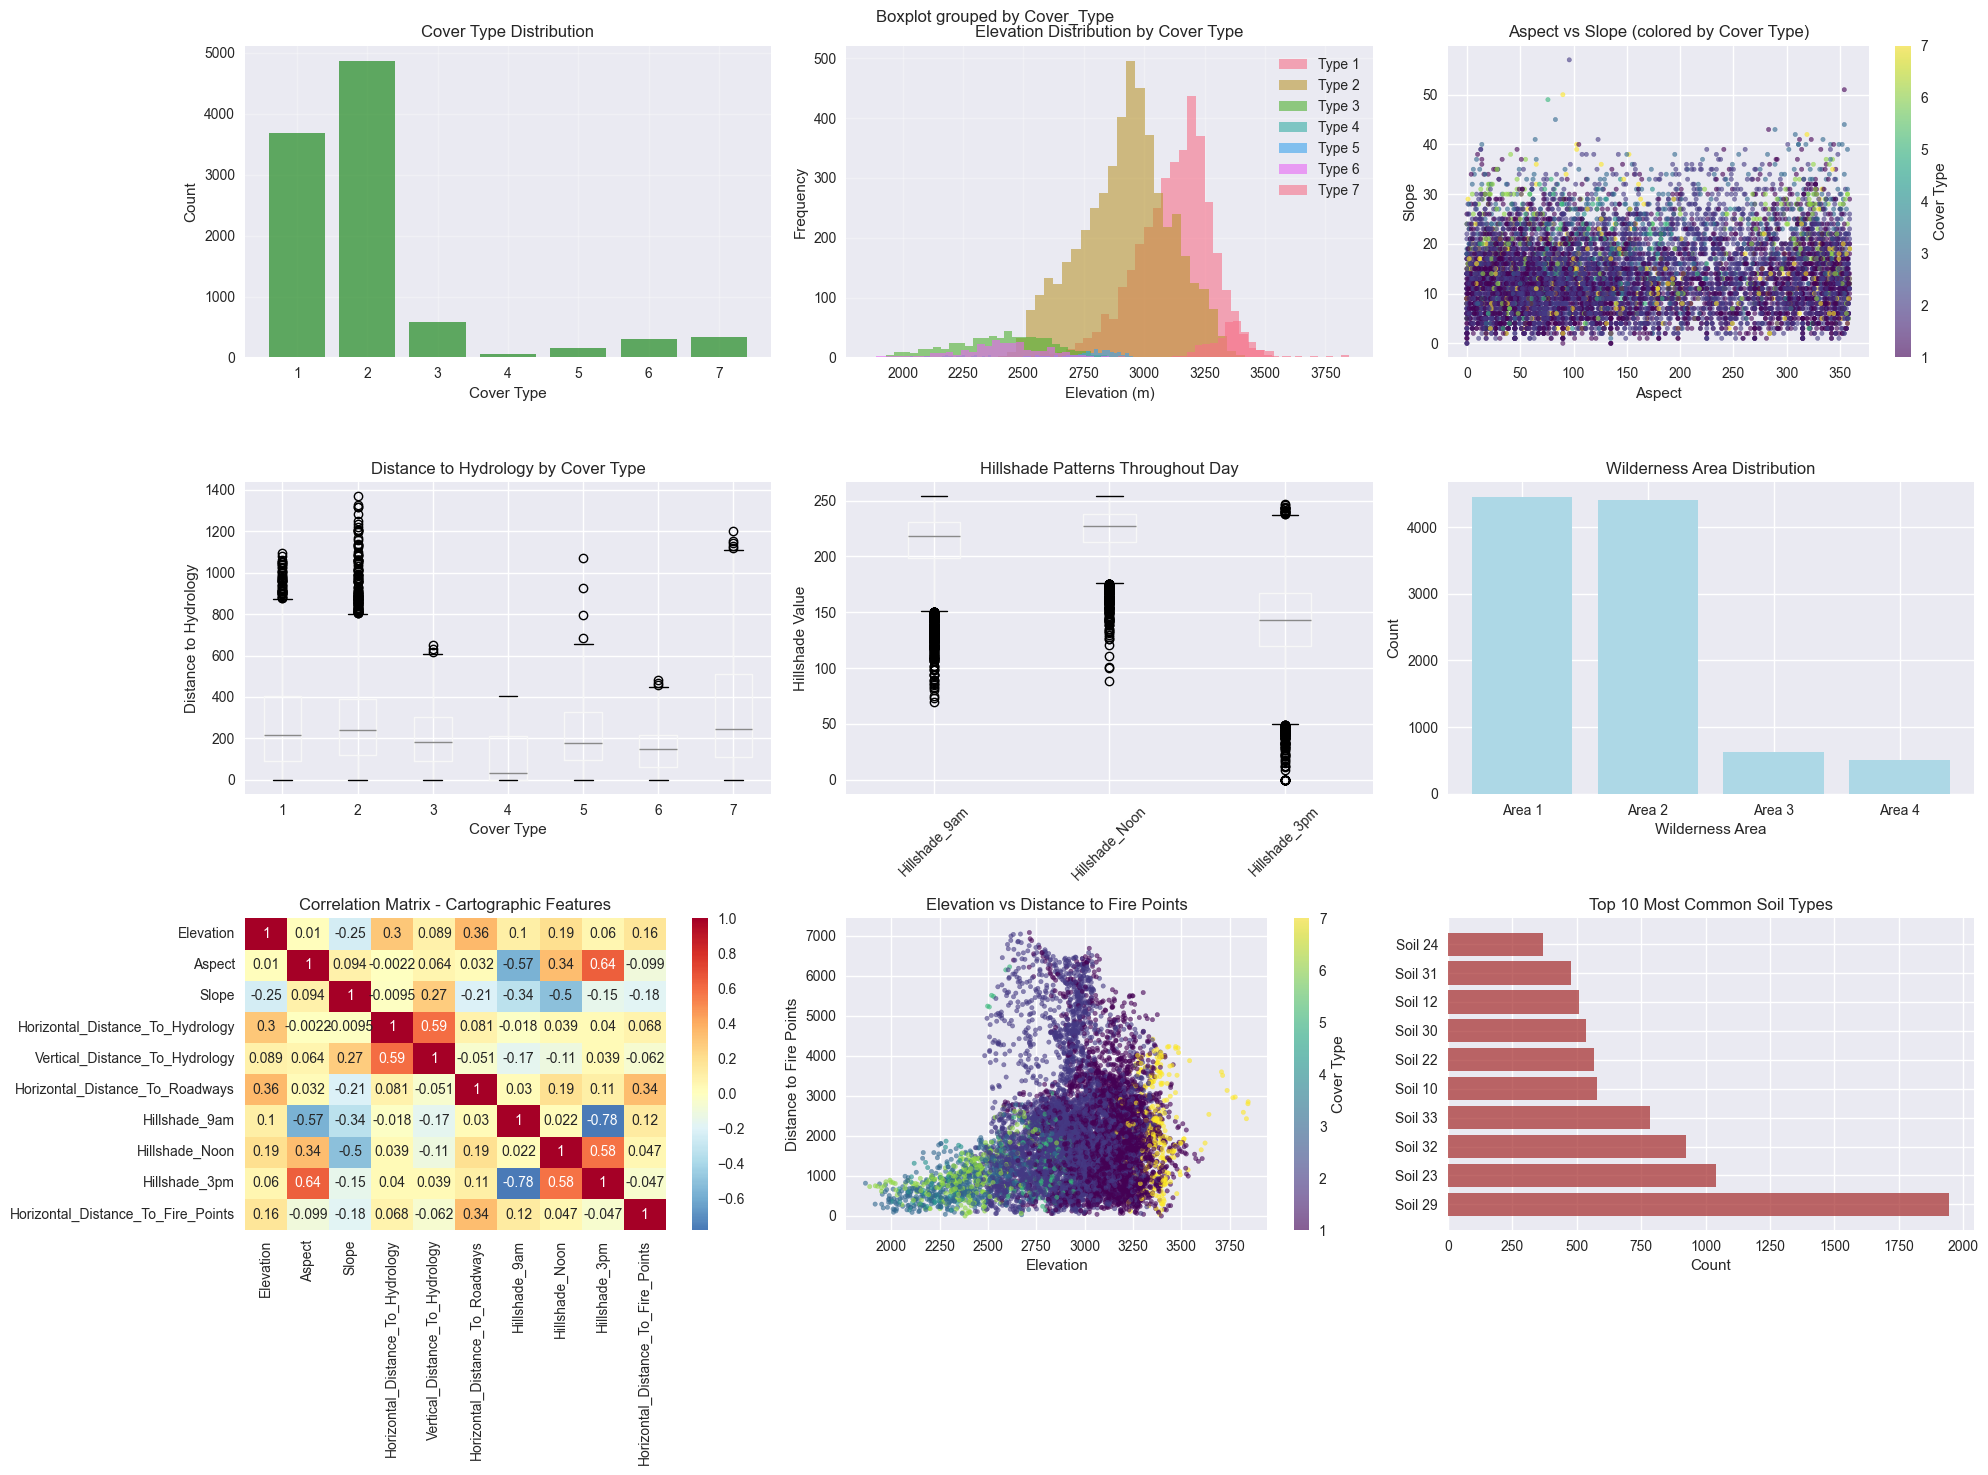

In [8]:
print("\n🔍 Step 2: Data Exploration and Visualization")
print("-" * 48)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Forest Cover Type - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Target distribution
axes[0, 0].bar(cover_type_counts.index, cover_type_counts.values, color='forestgreen', alpha=0.7)
axes[0, 0].set_title('Cover Type Distribution')
axes[0, 0].set_xlabel('Cover Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3)
for cover_type in sorted(df['Cover_Type'].unique()):
    subset = df[df['Cover_Type'] == cover_type]['Elevation']
    axes[0, 1].hist(subset, alpha=0.6, label=f'Type {cover_type}', bins=30)
axes[0, 1].set_title('Elevation Distribution by Cover Type')
axes[0, 1].set_xlabel('Elevation (m)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
scatter = axes[0, 2].scatter(df['Aspect'], df['Slope'], c=df['Cover_Type'], 
                            cmap='viridis', alpha=0.6, s=10)
axes[0, 2].set_title('Aspect vs Slope (colored by Cover Type)')
axes[0, 2].set_xlabel('Aspect')
axes[0, 2].set_ylabel('Slope')
plt.colorbar(scatter, ax=axes[0, 2], label='Cover Type')
df.boxplot(column='Horizontal_Distance_To_Hydrology', by='Cover_Type', ax=axes[1, 0])
axes[1, 0].set_title('Distance to Hydrology by Cover Type')
axes[1, 0].set_xlabel('Cover Type')
axes[1, 0].set_ylabel('Distance to Hydrology')
hillshade_cols = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
df[hillshade_cols].boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Hillshade Patterns Throughout Day')
axes[1, 1].set_ylabel('Hillshade Value')
axes[1, 1].tick_params(axis='x', rotation=45)
wilderness_counts = df[wilderness_areas].sum().sort_values(ascending=False)
axes[1, 2].bar(range(len(wilderness_counts)), wilderness_counts.values, color='lightblue')
axes[1, 2].set_title('Wilderness Area Distribution')
axes[1, 2].set_xlabel('Wilderness Area')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_xticks(range(len(wilderness_counts)))
axes[1, 2].set_xticklabels([f'Area {i+1}' for i in range(len(wilderness_counts))])
correlation_matrix = df[feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, ax=axes[2, 0])
axes[2, 0].set_title('Correlation Matrix - Cartographic Features')
scatter2 = axes[2, 1].scatter(df['Elevation'], df['Horizontal_Distance_To_Fire_Points'], 
                             c=df['Cover_Type'], cmap='viridis', alpha=0.6, s=10)
axes[2, 1].set_title('Elevation vs Distance to Fire Points')
axes[2, 1].set_xlabel('Elevation')
axes[2, 1].set_ylabel('Distance to Fire Points')
plt.colorbar(scatter2, ax=axes[2, 1], label='Cover Type')
soil_counts = df[soil_types].sum().sort_values(ascending=False).head(10)
axes[2, 2].barh(range(len(soil_counts)), soil_counts.values, color='brown', alpha=0.7)
axes[2, 2].set_title('Top 10 Most Common Soil Types')
axes[2, 2].set_xlabel('Count')
axes[2, 2].set_yticks(range(len(soil_counts)))
axes[2, 2].set_yticklabels([f'Soil {i.split("_")[2]}' for i in soil_counts.index])

plt.tight_layout()
plt.savefig('forest_exploration.png', dpi=150, bbox_inches='tight')
plt.show()


In [9]:
print("\n⚙️ Step 3: Feature Engineering")
print("-" * 32)
df_engineered = df.copy()
df_engineered['Distance_To_Hydrology_Roadways'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways']
df_engineered['Distance_To_Fire_Hydrology'] = df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Hydrology']
df_engineered['Hillshade_Mean'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
df_engineered['Hillshade_Range'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)
df_engineered['Elevation_Bin'] = pd.cut(df['Elevation'], bins=5, labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])

print(f"✅ Created {df_engineered.shape[1] - df.shape[1]} new features")



⚙️ Step 3: Feature Engineering
--------------------------------
✅ Created 5 new features


In [10]:
elevation_dummies = pd.get_dummies(df_engineered['Elevation_Bin'], prefix='Elevation')
df_engineered = pd.concat([df_engineered.drop('Elevation_Bin', axis=1), elevation_dummies], axis=1)

print(f"Final engineered dataset shape: {df_engineered.shape}")

Final engineered dataset shape: (10000, 64)


In [11]:
print("\n🎯 Step 4: Preparing Data for Modeling")
print("-" * 40)
X = df_engineered.drop('Cover_Type', axis=1)
y = df_engineered['Cover_Type']

print(f"Original target classes: {sorted(y.unique())}")


🎯 Step 4: Preparing Data for Modeling
----------------------------------------
Original target classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


In [12]:
y = y - 1  # Convert 1-7 to 0-6
print(f"Converted target classes: {sorted(y.unique())}")

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of classes: {len(y.unique())}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")


Converted target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Features shape: (10000, 63)
Target shape: (10000,)
Number of classes: 7

Data split:
   Training set: 8000 samples
   Test set: 2000 samples


In [13]:
print(f"\nClass distribution in training set:")
train_dist = y_train.value_counts().sort_index()
for class_type, count in train_dist.items():
    percentage = count / len(y_train) * 100
    print(f"   Type {class_type}: {count:4d} samples ({percentage:5.1f}%)")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features scaled using StandardScaler")


Class distribution in training set:
   Type 0: 2952 samples ( 36.9%)
   Type 1: 3901 samples ( 48.8%)
   Type 2:  472 samples (  5.9%)
   Type 3:   41 samples (  0.5%)
   Type 4:  129 samples (  1.6%)
   Type 5:  242 samples (  3.0%)
   Type 6:  263 samples (  3.3%)

✅ Features scaled using StandardScaler


In [14]:
print("\n🌳 Step 5: Random Forest Classification")
print("-" * 40)

print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)



🌳 Step 5: Random Forest Classification
----------------------------------------
Training Random Forest model...


In [15]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"✅ Random Forest Accuracy: {rf_accuracy:.4f}")
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"   Cross-validation scores: {rf_cv_scores}")
print(f"   CV Mean: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🎯 Top 10 Important Features (Random Forest):")
for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"   {row['Feature']:35}: {row['Importance']:.4f}")

✅ Random Forest Accuracy: 0.7870
   Cross-validation scores: [0.803125 0.79875  0.7775   0.769375 0.78125 ]
   CV Mean: 0.7860 (+/- 0.0257)

🎯 Top 10 Important Features (Random Forest):
   Elevation                          : 0.1509
   Horizontal_Distance_To_Roadways    : 0.0598
   Distance_To_Hydrology_Roadways     : 0.0554
   Horizontal_Distance_To_Fire_Points : 0.0514
   Distance_To_Fire_Hydrology         : 0.0509
   Horizontal_Distance_To_Hydrology   : 0.0467
   Vertical_Distance_To_Hydrology     : 0.0448
   Elevation_Medium                   : 0.0440
   Elevation_High                     : 0.0440
   Aspect                             : 0.0412


In [16]:
print("\n🚀 Step 6: XGBoost Classification")
print("-" * 36)

print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"✅ XGBoost Accuracy: {xgb_accuracy:.4f}")
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
print(f"   Cross-validation scores: {xgb_cv_scores}")
print(f"   CV Mean: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🎯 Top 10 Important Features (XGBoost):")
for idx, row in feature_importance_xgb.head(10).iterrows():
    print(f"   {row['Feature']:35}: {row['Importance']:.4f}")


🚀 Step 6: XGBoost Classification
------------------------------------
Training XGBoost model...
✅ XGBoost Accuracy: 0.7775
   Cross-validation scores: [0.79125  0.775625 0.765625 0.76375  0.765625]
   CV Mean: 0.7724 (+/- 0.0206)

🎯 Top 10 Important Features (XGBoost):
   Elevation_Medium                   : 0.5699
   Elevation_High                     : 0.0737
   Elevation                          : 0.0323
   Soil_Type_22                       : 0.0205
   Soil_Type_2                        : 0.0197
   Wilderness_Area_1                  : 0.0155
   Soil_Type_23                       : 0.0149
   Soil_Type_32                       : 0.0132
   Soil_Type_24                       : 0.0110
   Soil_Type_38                       : 0.0100


In [17]:
print("\n⚙️ Step 7: Hyperparameter Tuning (Bonus)")
print("-" * 42)
print("Tuning Random Forest hyperparameters...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,  # Reduced for speed
    scoring='accuracy',
    n_jobs=-1
)


⚙️ Step 7: Hyperparameter Tuning (Bonus)
------------------------------------------
Tuning Random Forest hyperparameters...


In [18]:
X_train_subset = X_train.sample(n=2000, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]

rf_grid_search.fit(X_train_subset, y_train_subset)

print(f"✅ Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"   Best CV score: {rf_grid_search.best_score_:.4f}")
best_rf = rf_grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)

print(f"   Best RF Test Accuracy: {best_rf_accuracy:.4f}")


✅ Best Random Forest parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Best CV score: 0.7265
   Best RF Test Accuracy: 0.7870


In [19]:
print("\nTuning XGBoost hyperparameters...")
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.2, 0.3]
}

xgb_grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42, n_jobs=-1),
    xgb_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

xgb_grid_search.fit(X_train_subset, y_train_subset)

print(f"✅ Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"   Best CV score: {xgb_grid_search.best_score_:.4f}")
best_xgb = xgb_grid_search.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)

print(f"   Best XGB Test Accuracy: {best_xgb_accuracy:.4f}")


Tuning XGBoost hyperparameters...
✅ Best XGBoost parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100}
   Best CV score: 0.7170
   Best XGB Test Accuracy: 0.8115



📊 Step 8: Model Evaluation and Visualization
------------------------------------------------


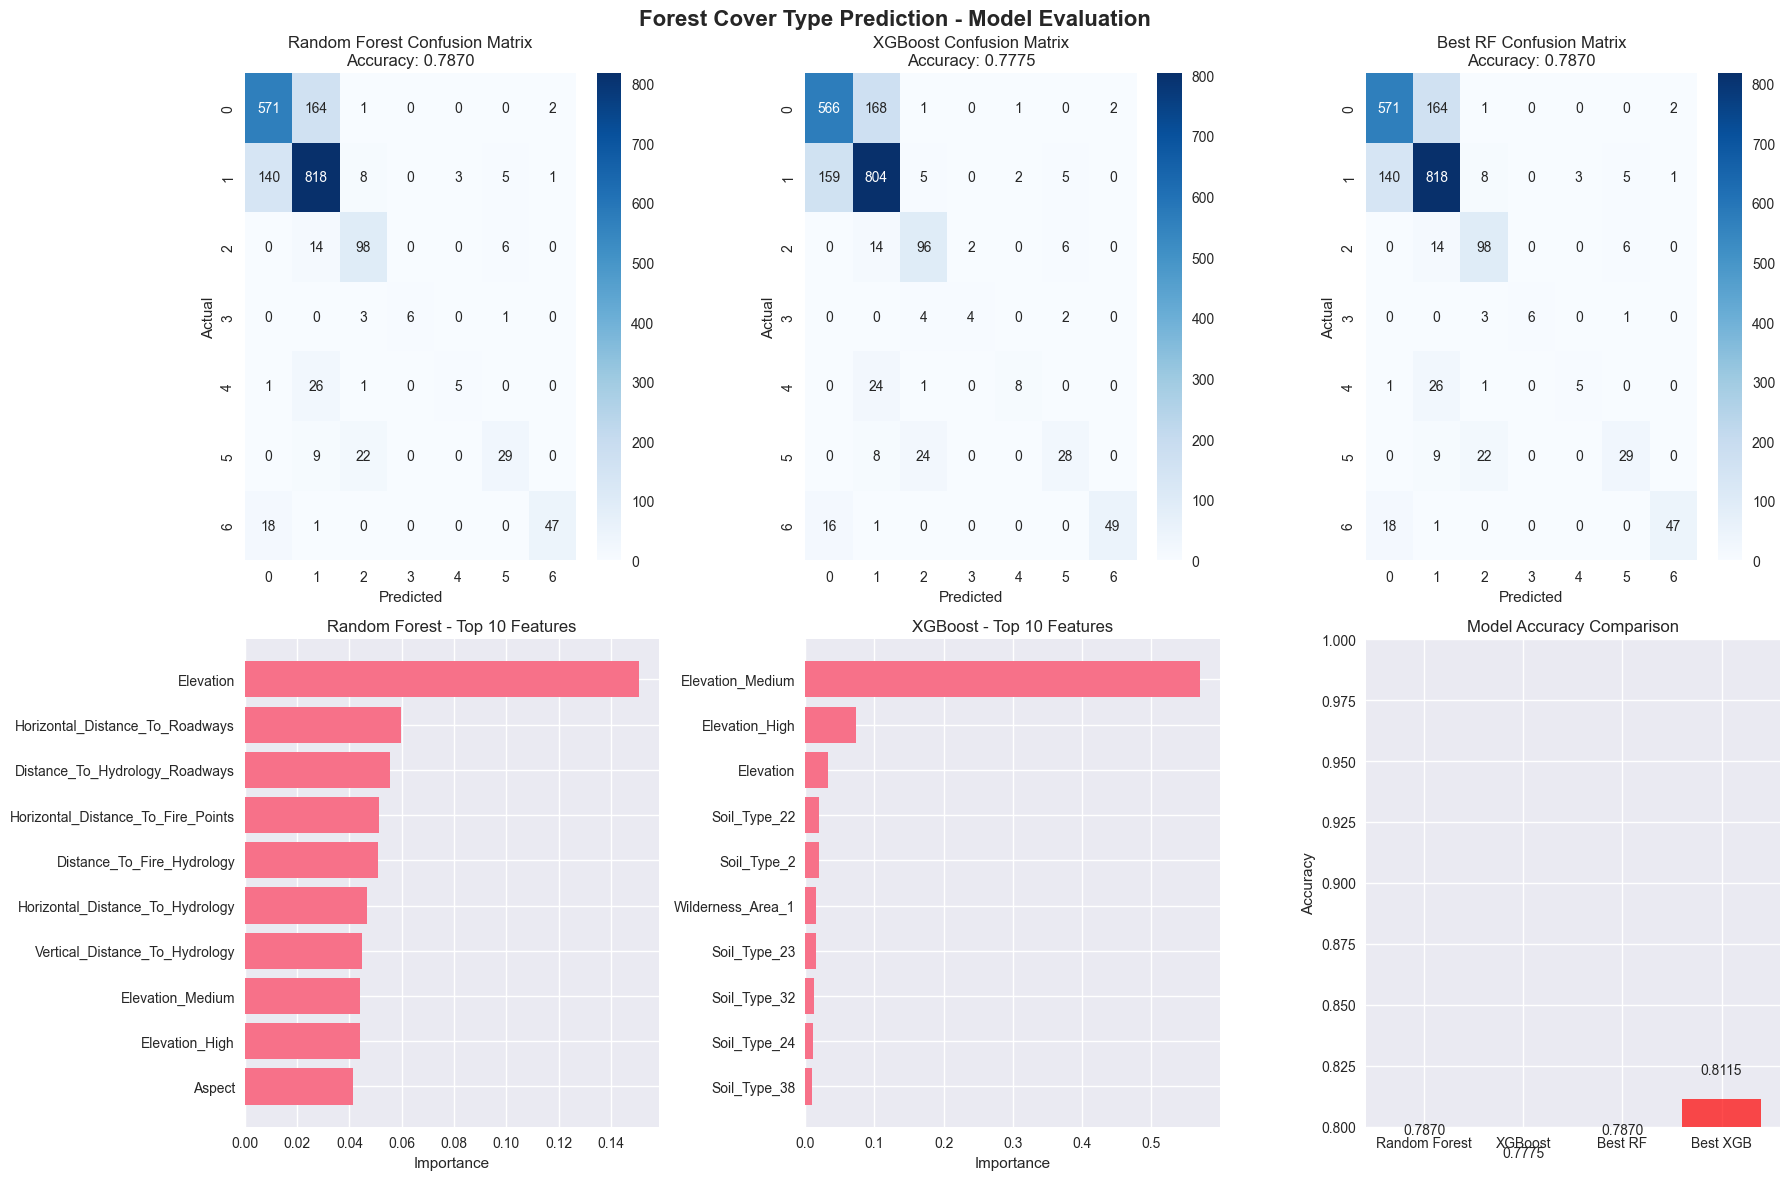

In [20]:
print("\n📊 Step 8: Model Evaluation and Visualization")
print("-" * 48)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Forest Cover Type Prediction - Model Evaluation', fontsize=16, fontweight='bold')

# Confusion matrices
models = [
    ("Random Forest", y_pred_rf, rf_accuracy),
    ("XGBoost", y_pred_xgb, xgb_accuracy),
    ("Best RF", y_pred_best_rf, best_rf_accuracy)
]

for i, (name, y_pred, accuracy) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{name} Confusion Matrix\nAccuracy: {accuracy:.4f}')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')
axes[1, 0].barh(range(10), feature_importance_rf.head(10)['Importance'].values[::-1])
axes[1, 0].set_yticks(range(10))
axes[1, 0].set_yticklabels(feature_importance_rf.head(10)['Feature'].values[::-1])
axes[1, 0].set_title('Random Forest - Top 10 Features')
axes[1, 0].set_xlabel('Importance')

axes[1, 1].barh(range(10), feature_importance_xgb.head(10)['Importance'].values[::-1])
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels(feature_importance_xgb.head(10)['Feature'].values[::-1])
axes[1, 1].set_title('XGBoost - Top 10 Features')
axes[1, 1].set_xlabel('Importance')
model_names = ['Random Forest', 'XGBoost', 'Best RF', 'Best XGB']
model_scores = [rf_accuracy, xgb_accuracy, best_rf_accuracy, best_xgb_accuracy]

axes[1, 2].bar(model_names, model_scores, color=['skyblue', 'lightgreen', 'orange', 'red'], alpha=0.7)
axes[1, 2].set_title('Model Accuracy Comparison')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_ylim(0.8, 1.0)
for i, score in enumerate(model_scores):
    axes[1, 2].text(i, score + 0.01, f'{score:.4f}', ha='center')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
print(f"\n📋 Detailed Classification Reports:")
print(f"\n🌳 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"\n🚀 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))



📋 Detailed Classification Reports:

🌳 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       738
           1       0.79      0.84      0.82       975
           2       0.74      0.83      0.78       118
           3       1.00      0.60      0.75        10
           4       0.62      0.15      0.24        33
           5       0.71      0.48      0.57        60
           6       0.94      0.71      0.81        66

    accuracy                           0.79      2000
   macro avg       0.80      0.63      0.68      2000
weighted avg       0.79      0.79      0.78      2000


🚀 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       738
           1       0.79      0.82      0.81       975
           2       0.73      0.81      0.77       118
           3       0.67      0.40      0.50        10
           4       0.7

In [23]:
print("\n💾 Step 9: Saving Models and Data")
print("-" * 35)
joblib.dump(best_rf, 'best_random_forest_model.pkl')
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print("✅ Saved models:")
print("   - best_random_forest_model.pkl")
print("   - best_xgboost_model.pkl")
print("   - feature_scaler.pkl")
model_info = {
    'feature_columns': list(X.columns),
    'target_classes': sorted(y.unique()),  # Now 0-6
    'original_target_classes': [1, 2, 3, 4, 5, 6, 7],  # Original 1-7
    'class_names': {
        0: 'Spruce/Fir',        # Originally class 1
        1: 'Lodgepole Pine',    # Originally class 2
        2: 'Ponderosa Pine',    # Originally class 3
        3: 'Cottonwood/Willow', # Originally class 4
        4: 'Aspen',             # Originally class 5
        5: 'Douglas-fir',       # Originally class 6
        6: 'Krummholz'          # Originally class 7
    },
    'class_mapping': {  # For converting predictions back to original labels
        0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7
    },
    'model_performance': {
        'random_forest': {
            'accuracy': rf_accuracy,
            'cv_mean': rf_cv_scores.mean(),
            'cv_std': rf_cv_scores.std()
        },
        'xgboost': {
            'accuracy': xgb_accuracy,
            'cv_mean': xgb_cv_scores.mean(),
            'cv_std': xgb_cv_scores.std()
        },
        'best_rf': {
            'accuracy': best_rf_accuracy,
            'best_params': rf_grid_search.best_params_
        },
        'best_xgb': {
            'accuracy': best_xgb_accuracy,
            'best_params': xgb_grid_search.best_params_
        }
    },
    'feature_importance_rf': feature_importance_rf.to_dict('records'),
    'feature_importance_xgb': feature_importance_xgb.to_dict('records')
}

joblib.dump(model_info, 'forest_model_info.pkl')
print("✅ Saved model information to 'forest_model_info.pkl'")



💾 Step 9: Saving Models and Data
-----------------------------------
✅ Saved models:
   - best_random_forest_model.pkl
   - best_xgboost_model.pkl
   - feature_scaler.pkl
✅ Saved model information to 'forest_model_info.pkl'
